# **1. 明确问题**

## *1.1 导入数据*

In [2]:
%matplotlib inline 
import matplotlib
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.stats.outliers_influence as vif
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', 60) 
pd.set_option('precision', 5)
import warnings
warnings.filterwarnings('ignore')

从网上导入泰坦尼克号沉船事故的公开数据，其中：
- SibSp指与该船员一起同行的其兄弟姐妹/配偶 加起来的人数
- Parch指与该船员一起同行的其儿女/父母 加起来的人数

In [3]:
titanic_df = pd.read_csv("titanic-data.csv")
titanic_df.head()# yapf: disable

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [5]:
allguys =titanic_df['PassengerId'].count()
alive = titanic_df[titanic_df['Survived']==1]['PassengerId'].count()
print('该数据中包含了%d条数据，其中有%d人存活' % (allguys,alive))

该数据中包含了891条数据，其中有342人存活


该数据集中包含了891条数据信息，其中有341条存活船员的信息

## *1.2 提出问题*

我希望能通过该数据回答我的$\, 2 \,$个问题：
1. 船上人员的生死与哪些因素有主要的关联 $?$
2. 每个相关因素对于人员的生死其影响程度有多大 $?$

备注：[数据背景介绍](https://www.kaggle.com/c/titanic/data)
<br>

# **2. 数据清理**

## *2.1 自变量选择*

- 首先发现该数据中有关年龄的内容存在着丢失，为保证数据具有较高的可信度  
这里并没有采用模拟年龄的分布去随机生成年龄来弥补缺失的数据，这里采用排除所有年龄有遗漏的数据。
- 鉴于登船港$\,[\,Embarked\,]\,$对于船上人员的生死并无实际意义，在此将其略去
- 同时船票信息$\,[\,Ticket\,]\,$，所在船舱并无实际意义所以略去。
- 因为船费$\,[\,Fare\,]\,$和与船舱等级$\,[\,Pclass\,]\,$高度相关，为了避免多重共线性，在这里主要以船舱等级作为因素进行后续考量，这里选择船舱等级作为解释变量( 因为在回归分析中船舱等级$\,[\,Pclass\,]\,$的解释力比船费$\,[\,Fare\,]\,$的解释性更强，同时更容易理解 )

## *2.2 性别数据观察*

([<matplotlib.axis.XTick at 0x2590b2355c0>,
 <a list of 2 Text xticklabel objects>)

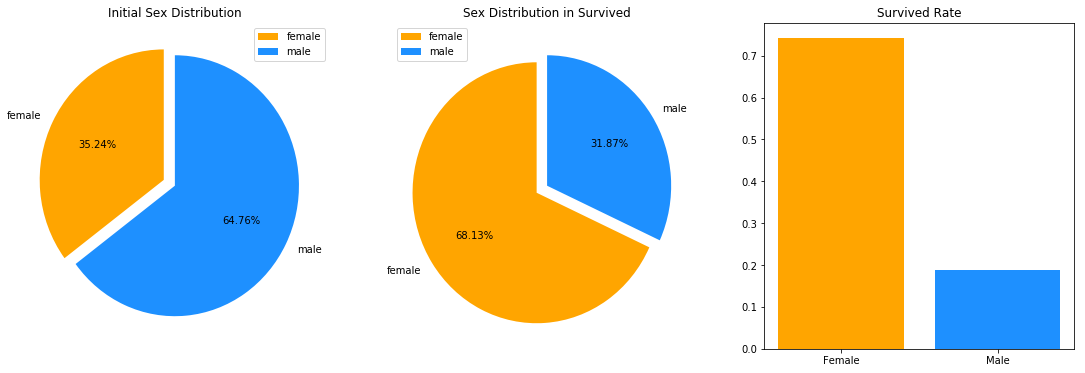

In [6]:
by_sex = titanic_df.groupby('Sex', as_index=False).count()  #所有数据中性别的分布
by_sex2 = titanic_df[titanic_df['Survived'] == 1].groupby(
    'Sex', as_index=False).count()  # 在存活的人中性别的分布
fig = plt.figure(figsize=(18.9, 6))
ax1 = plt.subplot(1, 3, 1)
plt.title('Initial Sex Distribution')
ax1.pie(by_sex['PassengerId'],labels=by_sex['Sex'],colors=['orange', '#1E90FF'],autopct='%1.2f%%',
        explode=[0.1, 0],startangle=90) # 画出初始数据中的性别分布
plt.legend()
ax2 = plt.subplot(1, 3, 2)
plt.title('Sex Distribution in Survived')
ax2.pie(by_sex2['Survived'],labels=by_sex2['Sex'],colors=['orange', '#1E90FF'],autopct='%1.2f%%',
        explode=[0.1, 0],startangle=90) # 画出生存数据中性别分布
plt.legend()
ax3=plt.subplot(1,3,3)
by_sex3 = titanic_df.groupby('Sex',as_index=False)['Survived'].mean()
index=np.arange(2)
plt.title('Survived Rate')
plt.bar(index,by_sex3['Survived'],color=['orange','#1E90FF'])
plt.xticks(index,('Female','Male'))

从数据中我们发现一个非常有趣的情况，在不考虑生存的情况下：女性 $\, \colon \,$ 男性 $ \, = \, 0.54 \, \colon \, 1$ 。  
当分析存活人里男女比例是发现：女性 $\, \colon \,$ 男性 $ \, = \, 2.14 \, \colon \, 1$，可以初步判断性别对于生存率有着非常显著的影响。

## *2.3 船舱等级[Pclass]数据观察*

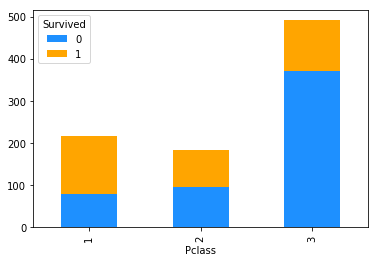

In [7]:
by_class=titanic_df.groupby(['Pclass','Survived'])['Survived'].count().unstack(). \
plot(kind='bar',stacked=True,color=['#1E90FF','orange']) # 画出船舱等级的分布特征

从船舱等级我们也看出来，一等舱的生存比例最高，二等舱生存率接近$ 50\% $,三等舱的生存率最低。  
由此我们初步判断生存率与船舱等级有显著的关联。

## *2.4 数据初步整理*

将数据中的性别进行虚拟变量转化（$\,女\,:\,1\, \,, \,男\,:\,0\,$）,同时去除丢失年龄的数据行。

In [8]:
titanic_df_agecleaned = titanic_df[titanic_df['Age'].notnull()]
sex_changelist = {'female': 1, 'male': 0}  # 对性别进行0-1转化
titanic_df_agecleaned_Sextrimed = titanic_df_agecleaned.replace(sex_changelist)
titanic_df_agecleaned_Sextrimed
titanic_df_allcleaned = titanic_df_agecleaned_Sextrimed[[
    'Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch']]  # 对不需要的数据进行清理，留下之后分析所需要的数据
titanic_df_allcleaned.head()

,Survived,Pclass,Sex,Age,SibSp,Parch
0,0,3,0,22.0,1,0
1,1,1,1,38.0,1,0
2,1,3,1,26.0,0,0
3,1,1,1,35.0,1,0
4,0,3,0,35.0,0,0


In [8]:
allguys1 =titanic_df_allcleaned['Sex'].count()
alive1 = titanic_df_allcleaned[titanic_df_allcleaned['Survived']==1]['Sex'].count()
print('经过清理后，数据中包含了%d条数据，其中有%d人存活' % (allguys1,alive1))

经过清理后，数据中包含了714条数据，其中有290人存活


最后，经过清理后数据大小为$714$条,其中存活人数为290人
与初始数据比较：有效总人数为原来的$80\%$，有效存活人数为原来的85%。  
可见数据删选后对整体数据结构并无实质影响。  
通过初步清理后，将分析用的数据整理为：Survival, Pclass, Sex, Age, SibSp, Parch五个方面的数据信息

## *2.5 年龄离散化*

对于年龄这个因素我们并不关心每大一岁会对生存有多大影响，更多的是想要只要不同年龄阶段之间对生存率所产生的差异。因此我们需要对年龄进行合理的分析处理，将连续变量离散化。  
为了能合理的对年龄进行分类，先以$5$年为一面元分析每一面元中的生存人数与/总人数之比。

In [9]:
pd.set_option('precision', 2)
cut_level = np.arange(85, step=5)  #对年龄以每5年为单位进行切片，为年龄分类寻找依据
survived_age = pd.cut(titanic_df_agecleaned_Sextrimed[titanic_df_agecleaned_Sextrimed['Survived']== 1]['Age'],
    bins=cut_level)
all_age = pd.cut(titanic_df_agecleaned_Sextrimed['Age'], bins=cut_level)
survived_dist = pd.DataFrame(pd.value_counts(survived_age))
survived_dist.columns = ['Survived']
all_dist = pd.DataFrame(pd.value_counts(all_age))
all_dist.columns = ['All']
survived_rate = pd.DataFrame(survived_dist['Survived'] / all_dist['All'])
survived_rate.columns = ['Rate']
table = survived_dist.join([all_dist['All'], survived_rate['Rate']])
table_ascend = table.iloc[[4, 11, 8, 3, 1, 0, 2, 5, 6, 7, 9, 10, 12, 15, 14, 13]]
table_ascend.T  #罗列各年龄区间的生存人数，总人数，生存率

,"(0, 5]","(5, 10]","(10, 15]","(15, 20]","(20, 25]","(25, 30]","(30, 35]","(35, 40]","(40, 45]","(45, 50]","(50, 55]","(55, 60]","(60, 65]","(65, 70]","(70, 75]","(75, 80]"
Survived,31.0,7.00,11.00,33.00,42.00,42.00,41.00,28.00,17.00,16.00,10.00,7.00,4.00,0.0,0.0,1.0
All,44.0,20.00,19.00,96.00,122.00,108.00,88.00,67.00,47.00,39.00,24.00,18.00,14.00,3.0,4.0,1.0
Rate,0.7,0.35,0.58,0.34,0.34,0.39,0.47,0.42,0.36,0.41,0.42,0.39,0.29,0.0,0.0,1.0


我们发现数据中在$(75,80]$年龄段中只有一个人(即样本数只有一个)，而且还存活了，导致这区域出现异常值(生存率$100\%$)，为保证数据的整体趋势性故在此将这年龄段剔除。

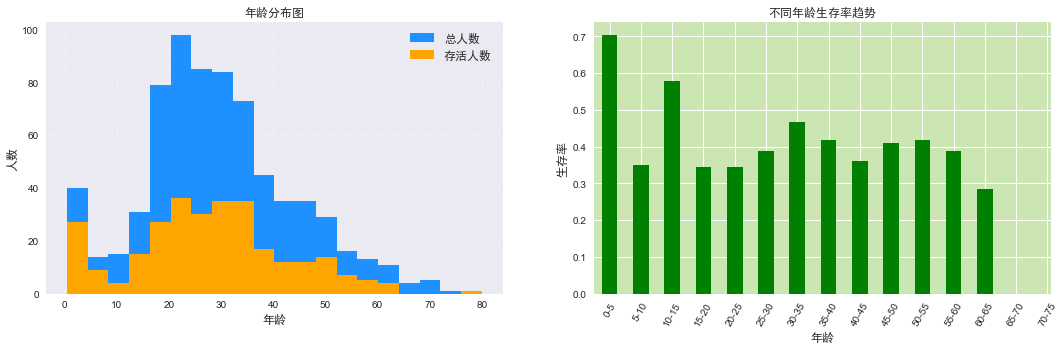

In [10]:
total_age_distrituion_without_nan = titanic_df[titanic_df['Age'].notnull()]
Survived_age = total_age_distrituion_without_nan[
    total_age_distrituion_without_nan['Survived'] == 1]['Age']
Survived_distribution = total_age_distrituion_without_nan[
    total_age_distrituion_without_nan['Survived'] == 1]
total_age_distrituion_without_nan.groupby(
    total_age_distrituion_without_nan['Sex']).count()
CHfont = matplotlib.font_manager.FontProperties(
    fname='C:\Windows\Fonts\simhei.ttf')
fig = plt.figure(figsize=(18, 5))
ax1 = plt.subplot(1, 2, 1)
plt.title(u'年龄分布图', fontproperties=CHfont)
plt.xlabel(u'年龄', fontproperties=CHfont, fontsize=12)
plt.ylabel(u'人数', fontproperties=CHfont, fontsize=12)
plt.grid(True, linestyle='--', alpha=0.3)
plt.hist(total_age_distrituion_without_nan['Age'], color='#1E90FF', bins=20)
plt.hist(Survived_age, bins=20, color='orange')
plt.legend(["总人数", "存活人数"], prop=CHfont)  #对年龄进行分区，寻找合适的年龄分类依据
ax2 = plt.subplot(1, 2, 2, facecolor=(0.8, 0.9, 0.7))
table_droped = table_ascend[:15]
x = np.arange(2.5, 77.5, 5)
plt.title(u'不同年龄生存率趋势', fontproperties=CHfont)
plt.xlim(0, 73)
plt.bar(x, table_droped['Rate'], color='green', width=2.5)
plt.xticks(x, ('0-5', '5-10', '10-15', '15-20', '20-25', '25-30', '30-35',
               '35-40', '40-45', '45-50', '50-55', '55-60', '60-65', '65-70',
               '70-75'),rotation=60,fontsize=10)
plt.xlabel(u'年龄', fontproperties=CHfont, fontsize=12)
plt.ylabel(u'生存率', fontproperties=CHfont, fontsize=12)

看出$(0\, ,5]$中生存率为$70.455\%$，而$>60$岁的生存率接近$0\%$，中间年龄生存率普遍差不多在$30\% \backsim 40\%$。  
在这里我们将年龄分成 **: **

|            |  ( 0-5 ]  |    ( 5-16 ]    |     ( 16-40]   |  ( 40-80 ]   |
| ---------: | :-------: | :------------: | :------------: | :--------- : |
|  标记      | $Age_1$    |    $Age_2$    |     $Age_3$     |   $Age_4$    |
| 年龄阶段    | 婴儿      |    青年        |       壮年      |    中老年      |  

# **3. 逻辑回归**

## *3.1 哑变量设置*

对于自变量中的两种定性变量（船舱等级，年龄阶段）设置哑变量以满足逻辑回归的要求：
- 在年龄阶段分析中以中老年阶段（age_4）作为比较对象
- 在船舱等级中以3等舱（class_4）作为比较对象  
<br>

|           |  年龄阶段  |	 $Age_1$  | $Age_2$  |  $Age_3$|  $Age_4$  |
| --------: | :--------: | :-------: | :------: | :-----: | :-------: |
|( 0-5 ]	|    婴儿	    |    1      |	0	   |    0    |  	0    |
|( 5-16 ]	|    青年	    |    0      |	1	   |    0    |   	0    |
|( 16-40 ]	|    壮年	    |    0      |  	0      |	1	 |      0     |
|( 40-80 ]	|    中老年   |	0	   |   0      |     0    |  	0    |  

|  Pclass   |  船舱等级  |  $Class_1$  |  $Class_2$  | $Class_3$  |
| :-------: | :-------: | :--------: | :----------: | :--------: |
|   1    	|	一等舱   |     1	  |      0        |  	0      |
|   2	    |   二等舱   |	    0	   |     1        |  	0      |
|   3    	|   三等舱   |	    0      |   	0         |  	0      |
<br>

## *3.2 数据分组：训练组 & 测试组*

在这里使用statsmodels包里的logit函数进行逻辑回归分析，首先对数据做一下整理：
1. 首先将数据整理成满足该函数要求的表格形式
2. 将数据按 $3：1$ 的比例分成两组数据：训练数据，测试数据

In [11]:
slice1 = pd.cut(titanic_df_allcleaned['Age'], bins=[0, 5, 15, 40, 80])
dummy_age = pd.get_dummies(slice1)
dummy_age.columns = ['age_1', 'age_2', 'age_3', 'age_4']
dummy_class = pd.get_dummies(titanic_df_allcleaned['Pclass'], prefix='class')  #使用get_dummies获得哑变量
cols_to_keep = ['Survived', 'Sex', 'SibSp', 'Parch']
good_data = titanic_df_allcleaned[cols_to_keep].join(
    [dummy_age.loc[:, ['age_1', 'age_2', 'age_3']], dummy_class.loc[:, :'class_2']])
good_data['intercept'] = 1.0
test_data = good_data.iloc[np.arange(716, step=4)]
train_data_temp = good_data[good_data.isin(test_data) ==False]  #训练数据用于拟合模型，测试数据用于检验模型
train_data = train_data_temp.dropna()
good_data.head()

,Survived,Sex,SibSp,Parch,age_1,age_2,age_3,class_1,class_2,intercept
0,0,0,1,0,0,0,1,0,0,1.0
1,1,1,1,0,0,0,1,1,0,1.0
2,1,1,0,0,0,0,1,0,0,1.0
3,1,1,1,0,0,0,1,1,0,1.0
4,0,0,0,0,0,0,1,0,0,1.0


## 3.3 多重共线性检验

引入哑变量作为解释变量时，为避免产生完全多重共线的问题，这里选择不将$Class_3，Age_4$引入数据中   

这里通过查看自变量间的相关系数矩阵，来初步判断是否存在多重共线的问题 **：**

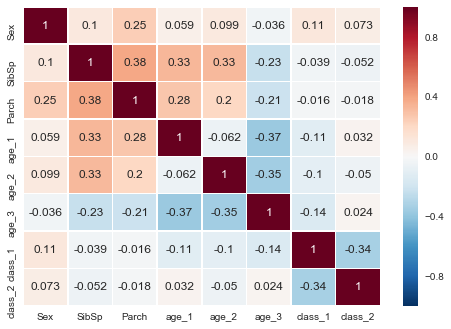

In [12]:
exog = good_data.drop(["Survived","intercept"],axis=1)
sns.heatmap(exog.corr(),annot=True,linewidths=.5) 

上图发现自变量因素之间的相关系数$r_{ij}<<0.8$，故可以基本排除多重共线性的情况:  

同时使用VIF检验的定量方法进步查看多重共线问题**：**

In [13]:
cols = exog.columns
x_name=list();x_vif=list()
for i in np.arange(len(cols)):
    a= vif.variance_inflation_factor(exog.values,i)
    x_vif.append(a)
    x_name.append(cols[i])
pd.DataFrame(list(zip(x_name,x_vif)),columns=[r"$Explanatory Variable$",r"$VIF_i$"])

,$Explanatory Variable$,$VIF_i$
0,Sex,1.74
1,SibSp,1.80
2,Parch,1.61
3,age_1,1.38
4,age_2,1.32
5,age_3,1.67
6,class_1,1.31
7,class_2,1.35


从上表可以看出每个自变量的 $VIF_i$ 均$\,<\,5\,$,可以排除所选择的解释变量间存在多重共线性的可能。

## *3.4 初步拟合*

将得到的训练数据（train_data）进行逻辑回归拟合得到下方表格:

In [14]:
train_cols = train_data.columns[1:]
logit = sm.Logit(train_data['Survived'], train_data[train_cols])
result = logit.fit()
result.summary()  # 使用logit()函数进行初步拟合

Optimization terminated successfully.
         Current function value: 0.429577
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Survived   No. Observations:                  535
Model:                          Logit   Df Residuals:                      526
Method:                           MLE   Df Model:                            8
Date:                Sun, 04 Jun 2017   Pseudo R-squ.:                  0.3624
Time:                        06:17:24   Log-Likelihood:                -229.82
converged:                       True   LL-Null:                       -360.46
                                        LLR p-value:                 6.985e-52
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Sex            2.8375      0.266     10.657      0.000       2.316       3.359
SibSp         -0.4710      0.156     -3.021      0.003      -0.777      -0.165
Parch         -0.1561      0.142     -1.100      0.271      -0.434       0.122
age_1          3.6228      0.680      5.331      0.000       2.291       4.955
age_2          1.6899      0.634      2.665      0.008       0.447       2.933
age_3          0.8045      0.304      2.648      0.008       0.209       1.400
class_1        2.2832      0.314      7.265      0.000       1.667       2.899
class_2        1.0852      0.293      3.703      0.000       0.511       1.659
intercept     -2.9283      0.356     -8.232      0.000      -3.625      -2.231
==============================================================================
"""

## *3.5 模型校验*

表中发现因素Parch（即携带子女+父母）的$\,P\,值 = 0.271$，即无统计意义，须将其从模型中移除。其余因素的$P值<0.01$，十分显著。  

将Parch剔除之后再次重复之前的拟合流程，有下面分析：

In [15]:
test_data_1 = test_data.drop('Parch', axis=1)
train_data_1 = train_data.drop('Parch', axis=1)  #将Parch因素剔除，再行进行拟合
train_cols_1 = train_data_1.columns[1:]
logit_1 = sm.Logit(train_data_1['Survived'], train_data_1[train_cols_1])
result_1 = logit_1.fit()
result_1.summary()

Optimization terminated successfully.
         Current function value: 0.430731
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Survived   No. Observations:                  535
Model:                          Logit   Df Residuals:                      527
Method:                           MLE   Df Model:                            7
Date:                Sun, 04 Jun 2017   Pseudo R-squ.:                  0.3607
Time:                        06:17:24   Log-Likelihood:                -230.44
converged:                       True   LL-Null:                       -360.46
                                        LLR p-value:                 2.014e-52
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Sex            2.7656      0.256     10.819      0.000       2.265       3.267
SibSp         -0.5076      0.153     -3.324      0.001      -0.807      -0.208
age_1          3.5417      0.679      5.217      0.000       2.211       4.872
age_2          1.6699      0.627      2.661      0.008       0.440       2.900
age_3          0.8235      0.302      2.726      0.006       0.231       1.416
class_1        2.2985      0.314      7.323      0.000       1.683       2.914
class_2        1.1074      0.292      3.790      0.000       0.535       1.680
intercept     -2.9728      0.354     -8.404      0.000      -3.666      -2.279
==============================================================================
"""

可以看出模型中每个自变量均通过显著性检验，这里给出生存率$\,P\,$的逻辑回归模型的数学表达式：

$$
\begin{align}\ln{p \over (1-p)} =& -2.973 + 2.766 \cdot Sex + -0.508 \cdot SibSp + (3.542\cdot Age_1+1.670\cdot Age_2 +0.824\cdot Age_3)\\
&(+2.299\cdot Class_1+1.107\cdot Class_2)
\end{align}
$$

## *3.6 模型拟合效果测试*

现在用test_data去测试下模型得到的生存情况与测试数据的的实际情况的匹配情况**:**

In [16]:
predict_cols = test_data_1.columns[1:9]  #利用测试数据进行模型测试，其中阈值选择为0.5
test_data_1['predict'] = result_1.predict(test_data_1[predict_cols])
rate_max=0;cut_best=0.5;total_best = 0;hit_best = 0
xulie = np.arange(1.01,step=0.01)
for i in xulie:
    total = 0
    hit = 0
    for value in test_data_1.values:
        predict = value[-1]
        survived = int(value[0])
        if predict > i:
            total += 1
            if survived == 1:
                hit += 1
        else:
            total += 1
            if survived == 0:
                hit += 1
    rate=hit / total
    if rate > rate_max:
        rate_max=rate;cut_best=i;total_best =total;hit_best = hit
print('当阈值设为%.2f时，Total: %d, Hit: %d, Precision: %.2f%%' % (cut_best,total_best, hit_best,100.0 * hit_best / total_best))

当阈值设为0.34时，Total: 179, Hit: 147, Precision: 82.12%


我们看到当把阈值设置为$0.34$时（即当模型给出的预测生存率 $>0.34$,则认为生存），其 ** $Prob（预测结果=测试数据实际结果） = 82.12\% $ **    
可见模型的拟合效果十分理想。  
阈值$\,:\,0.34$是通过迭代将$[\,0\,,\,1\,]$ 的所有值按间隔：$0.01$遍历，得到的能使测试概率最高的阈值  
阈值为$0.34$说明：本次事故的生存率实在太低了。对于该事故而言：  
若$阈值\,<\,0.34$，则悲观估计了其生存率  
若$阈值\,>\,0.34$，则乐观估计了其生存率
  


# **4 结果分析**

## *4.1 各因素优势比率分析*

列出各因素的优势比率, 及其$95\%$的置信区间：

In [17]:
params = result_1.params
conf = result_1.conf_int() # 罗列各自变量的优势比率
conf['OR'] = params
conf.columns = ['2.5%', '97.5%', 'OR']
np.exp(conf)

,2.5%,97.5%,OR
Sex,9.63,26.22,15.89
SibSp,0.45,0.81,0.60
age_1,9.13,130.62,34.53
age_2,1.55,18.17,5.31
age_3,1.26,4.12,2.28
class_1,5.38,18.43,9.96
class_2,1.71,5.37,3.03
intercept,0.03,0.10,0.05


上表中我们可以得到一下结论：
1. 在固定其他因素下：女性的生存概率是男性的**$\, 15.9 \, $倍**
2. 在固定其他因素下：每多携带一名配偶/兄妹时，其生存概率就会**下降**到原先的**$\, 60\%\, $**
3. 在固定其他因素下：婴儿的生存概率是中老年的**$\, 34.5\, $倍**，青年的生存概率是中老年的**$\, 5.3\, $倍**，壮年的生存概率是中老年的**$\, 2.3\, $倍**
4. 在固定其他因素下：一等舱的生存概率是三等舱的**$\, 10\, $倍**,二等舱的生存概率是三等舱的**$\, 3.0\, $倍**  


- 一等舱的人比其他的人生存率高是非常好理解的吗，因为富有的人可以调用的资源多。  
- 每多携带一名配偶/兄妹时，其生存概率会下降，说明在本次海难中年龄相仿的越多不但帮不上忙，反而还帮倒忙。  
- 女性和婴儿的生存率非常的高。这两类群体本应是求生能力最弱的群体里的，结果却表示其生存能力最佳，这与显示理解差距非常大，甚至会使我们怀疑模型结果的可信度。但当进步研究沉船事故记录可以发现——当时事故发生后的弃船逃生的过程中，泰坦尼克号的船长曾下令：优先抢救儿童和妇女。从我们的数据分析中可以下该结论：这条命令的效果是非常明显的。

## *4.2 结果可信度分析*

上述的分析的逻辑严谨，遵从统计原理，同时充分考虑的各自变量可能存在的多重共线性，并且在模拟过程中剔除了不显著的自变量Parch，使得其分析过程非常可靠。所以影响结论的可靠程度的主要方面更多的是来自数据的可信度 ：
1. 首先该数据来源方面，该数据由Kaggle网站提供其数据的真实性非常高
2. 当时船上全员有$2208$人,最后存活了$705$人.数据来源：[泰坦尼克号](http://baike.baidu.com/link?url=1MGqHgSCJXgrrVrfpPD2v9aQxYzB13yPf6uDISQO-2o3ZfmZXw5xR6YrG8-kCNhqnVEPu6ZeJ2HtGeHBuvxtHZQ_g4ouDXkJ91a4LtLNeDtpXyl3MJLcatHqDxYj9KiC)  该数据中有$891$条人员的信息，其中有342人存活。  
该份数据的有效人数为历史总人数的**$40.4\%$** ,生存人数为历史总人数的$ 48.5\% $, 样本数据具有很好的代表性，使得得到的结论有较多可信度。  


## *4.3 适用性分析*

该分析结果用在此次泰坦尼克号沉船事件中是适用可信的，但要将这个结果推广到所有邮轮海难的生存率分析其就非常不可信； ，原因有：  
1. 该数据量仅为891条，对于整个总体而言，样本量太过于小，使得将结论进行推广时其没有可信度
2. 数据仅来自一次邮轮海难，无法代表所有邮轮海难的全体特征
3. 该数据的发生的时间太久，无法代表现代邮轮海难所实际面临的情况，其自变量对生存率的影响与当时有很大不同
4. 其数据中包含的信息比较少，仍存在丢失重要影响因素的情况：如邮轮海难后生存率还应与船上救生艇的总体容量有直接关系等。